## Using GPU

In [1]:
!nvidia-smi

Wed Jul  3 16:20:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Downloading the data : food vision

In [2]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-07-03 16:20:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 142.250.152.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip'

10_food_classes_all 100%[===================>] 495.13M   230MB/s    in 2.2s    

2024-07-03 16:20:53 (230 MB/s) - '10_food_classes_all_data.zip' saved [519183241/519183241]



## Install Dependencies and Setup

In [3]:
!pip install -q numpy matplotlib seaborn tensorflow tensorflow-model-optimization

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input

2024-07-03 16:21:25.106678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 16:21:25.106798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 16:21:25.244878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Data and Setup

In [5]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [6]:
# setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

## Data Preprocesssing

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                  image_size = IMAGE_SHAPE,
                                                                  label_mode = "categorical", # what type are the labels?
                                                                  batch_size = BATCH_SIZE) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                 image_size = IMAGE_SHAPE,
                                                                 label_mode = "categorical",
                                                                 shuffle = False)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


EfficientNetV2B0 CNN models input does not need the rescaling

In [8]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Transfer Learning : EfficientNetV2B0

In [9]:
# Create base model with tf.keras.applications
base_model = EfficientNetV2B0(include_top=False) # Updated version of EfficientNetB0

# Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# Create inputs into the base model
inputs = Input(shape = IMAGE_SHAPE + (3,), name="input_layer")

# Pass the inputs to the base_model (note: EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
efficientnetv2_model = Model(inputs, outputs)

# Compile the model
efficientnetv2_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [10]:
efficientnetv2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [11]:
# Fit the model
efficientnetv2_history = efficientnetv2_model.fit(train_data,
                                 epochs = 50,
                                 steps_per_epoch = len(train_data),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
)

Epoch 1/50


2024-07-03 16:21:53.300997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  2/235 [..............................] - ETA: 13s - loss: 2.2659 - accuracy: 0.1562  

I0000 00:00:1720023717.557740     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - 29s 72ms/step - loss: 0.8450 - accuracy: 0.7705 - val_loss: 0.4933 - val_accuracy: 0.8602
Epoch 2/50
235/235 [==============================] - 14s 56ms/step - loss: 0.4756 - accuracy: 0.8567 - val_loss: 0.3680 - val_accuracy: 0.8947
Epoch 3/50
235/235 [==============================] - 14s 57ms/step - loss: 0.4016 - accuracy: 0.8807 - val_loss: 0.3355 - val_accuracy: 0.8914
Epoch 4/50
235/235 [==============================] - 14s 58ms/step - loss: 0.3676 - accuracy: 0.8877 - val_loss: 0.3092 - val_accuracy: 0.9030
Epoch 5/50
235/235 [==============================] - 14s 58ms/step - loss: 0.3371 - accuracy: 0.8991 - val_loss: 0.3069 - val_accuracy: 0.9030
Epoch 6/50
235/235 [==============================] - 14s 57ms/step - loss: 0.3194 - accuracy: 0.9005 - val_loss: 0.2702 - val_accuracy: 0.9128
Epoch 7/50
235/235 [==============================] - 14s 57ms/step - loss: 0.2984 - accuracy: 0.9067 - val_loss: 0.2802 - val_accuracy: 0.9095
Epo

## Evaluating the Classification task

In [12]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# plot the confusion matrix to see the positive instances of all classes
def confusion_net(model_0,test_data1):
    # Predicting the test data
    test_predictions = model_0.predict(test_data1)

    # Converting predictions to class labels
    test_predictions_labels = [np.argmax(i) for i in test_predictions]

    # Extracting the true labels from the test dataset
    true_labels = []
    for images, labels in test_data1:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))

    # Calculating the confusion matrix
    cm = tf.math.confusion_matrix(labels=true_labels, predictions=test_predictions_labels)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

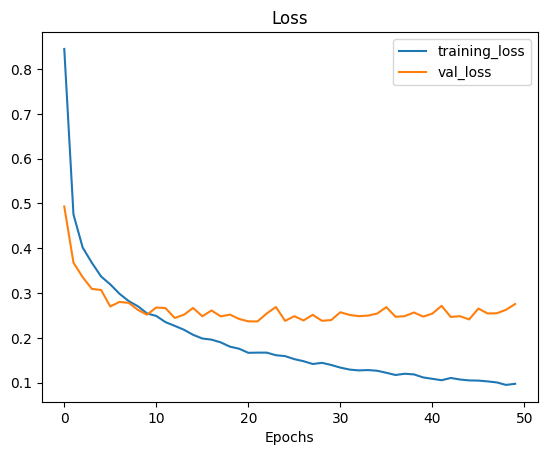

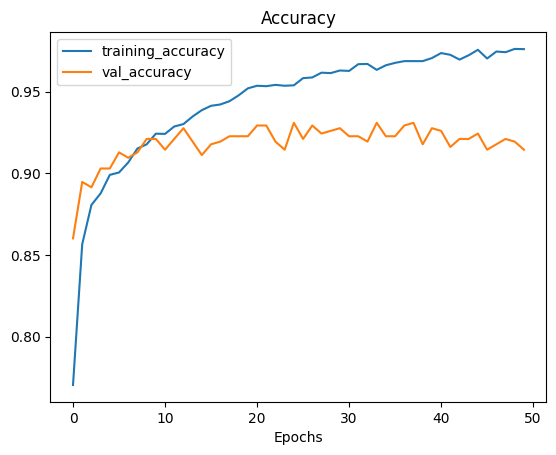

In [13]:
plot_loss_curves(efficientnetv2_history)

79/79 [==============================] - 7s 63ms/step


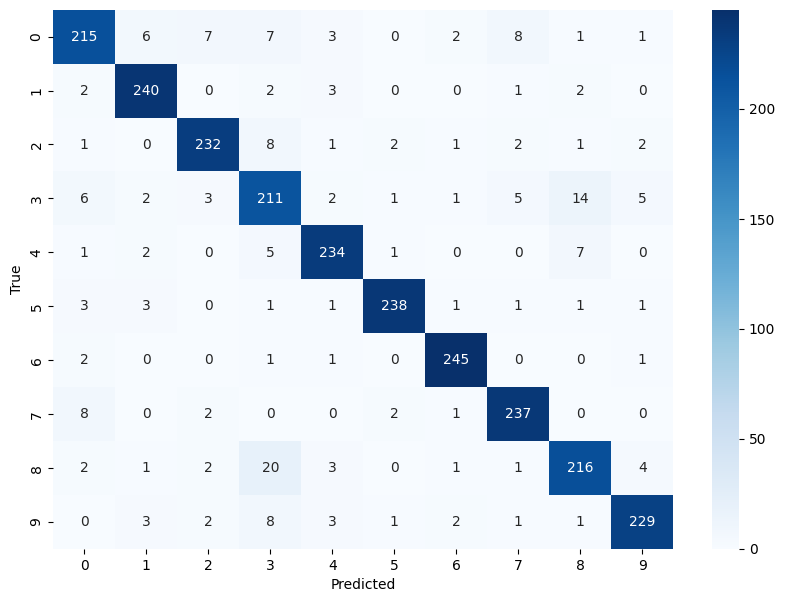

In [14]:
confusion_net(efficientnetv2_model,test_data)

In [19]:
efficientnetv2_model.save('food_vision_model.h5')